# <div style="text-align:center; padding:15px; color:white; margin:0; font-size:150%; font-family:'Times New Roman'; background-color:#7E8083   ; overflow:hidden"><b>Import libraries and load data</b></div>

In [72]:
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [63]:
dir = '../../data/predict/dataset/10k-15k'
input_size: int  # 每个时间步的输入特征数量
hidden_size = 64
output_size = 3  # 假设每个任务预测3个标签（库的提交数量）
num_tasks: int    # 假设有3个库

In [64]:
def process(all):
    data = all.copy().drop(columns=['Core Developers Focus Rate'])
    # data['Target'] = data['Target'].apply(lambda x: ast.literal_eval(x)[0] if x != '[]' else 0)

    # 计算变化百分比
    # data['Target'] = (data['Target'] - data['Commit Count']) / data['Commit Count']

    # 创建新列，根据变化比例进行分类
    # def categorize_change(row):
    #     if abs(row['Target']) > 0.3:  # 超过30%
    #         return 1 if row['Target'] > 0 else 0
    #     else:
    #         return 2  # 未超过30%

    # get_dummies(data['Target'], prefix='Target')


    # data['code_per_file'] = data['Code Lines'] / data['Code Files']
    # data = data[data['Target'] < 400]
    data = data[data['Develop Time'] > 0]

    # data['code_line_delta'] = data['Added Code Lines'] - data['Removed Code Lines']
    # data['code_per_commit'] = (data['Added Code Lines'] + abs(data['Removed Code Lines'])) / data['Commit Count']

    data["Fork Count"] = data["Fork Count"].apply(lambda x: x if x != 0 else 1)
    data["Modified File Count (Average)"] = data["Modified File Count (Average)"].astype(int)

    data["PR Length"] = data["PR Length"].astype(int)
    data["PR Length"] = data["PR Length"].replace(0, np.nan)
    data["Created PRs"] = data["Created PRs"].replace(0, np.nan)
    data["Closed PRs"] = data["Closed PRs"].replace(0, np.nan)
    data["Created Issues"] = data["Created Issues"].replace(0, np.nan)
    data["Closed Issues"] = data["Closed Issues"].replace(0, np.nan)

    data = data.replace(np.inf, np.nan)

    data = data.apply(lambda x: x.fillna(x.mean()), axis=0)
    data["PR Length"] = data["PR Length"].astype(int)
    data["Created PRs"] = data["Created PRs"].astype(int)
    data["Closed PRs"] = data["Closed PRs"].astype(int)
    data["Created Issues"] = data["Created Issues"].astype(int)
    data["Closed Issues"] = data["Closed Issues"].astype(int)
    data["Label Counts (Average)"] = data["Label Counts (Average)"].astype(int)
    data["Target"] = data["Target"].astype(int)

    # # data["PR Length"] = data["PR Length"].astype(int)

    # data = data.drop(columns=['Bot Commit', 
    #                         'Reopened Issues', 
    #                         'Release Count','Download Count', 
    #                         'Markdown Files', 'Markdown Lines',
    #                         'Code Files', 'Code Lines',
    #                         'Bot Commit', 'Truck Factor',
    #                         'Code Comments',
    #                         "PR Length"])

    # data = data.drop(columns=['Commit Count'])

    return data

def count_files_in_directory(directory):
    tensor_list = []
    i = 0
    # 获取目录下的所有文件和文件夹
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.is_file():
                df = pd.read_csv(entry)
                if len(df) < 10:
                    continue
                i += 1

                df['Target'] = df['Commit Count'].shift(-1)
                df['Target'] = df['Target'].dropna()

                tensor_list.append(process(df))

    return tensor_list, i

data, num_tasks = count_files_in_directory(dir)
input_size = data[0].shape[1]

In [65]:
# 定义数据集
class MultiLabelDataset(Dataset):
    def __init__(self, data):
        self.data = data  # data是一个list，包含多个库的提交历史数据

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 假设每个库的数据是一个时间序列，返回特征和多标签
        library_data = self.data[idx]
        X = library_data.drop("Target", axis=1)
        y = library_data["Target"].copy()


        return torch.tensor(X.to_numpy(), dtype=torch.float32), torch.tensor(y.to_numpy(), dtype=torch.float32)

In [66]:
# 自定义collate函数以处理动态填充
def collate_fn(batch):
    inputs, targets = zip(*batch)
    padded_inputs = pad_sequence(inputs, batch_first=True)  # 动态填充输入
    padded_targets = pad_sequence(targets, batch_first=True)  # 动态填充目标
    return padded_inputs, padded_targets

In [67]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)


dataset = MultiLabelDataset(X_train)
X_test = MultiLabelDataset(X_test)


In [83]:
# 定义多任务LSTM模型
class MultiTaskLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MultiTaskLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[-1:, -1, :]  # 取最后一个时间步的输出
        return self.fc(last_out)

In [84]:
# 创建模型
model = MultiTaskLSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [85]:
# 训练模型
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


for epoch in range(50):  # 训练50个epoch
    for inputs, targets in dataset:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(-1))  # 添加一个维度以适应LSTM输入
        loss = criterion(outputs, targets[-3:])  # 所有任务的损失相加
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

Epoch 1, Loss: 2281.547607421875
Epoch 2, Loss: 2215.451904296875
Epoch 3, Loss: 2117.1689453125
Epoch 4, Loss: 2019.2264404296875
Epoch 5, Loss: 1919.4813232421875
Epoch 6, Loss: 1832.3973388671875
Epoch 7, Loss: 1750.27880859375
Epoch 8, Loss: 1680.4287109375
Epoch 9, Loss: 1614.8638916015625
Epoch 10, Loss: 1555.96337890625
Epoch 11, Loss: 1495.4443359375
Epoch 12, Loss: 1443.0858154296875
Epoch 13, Loss: 1394.0853271484375
Epoch 14, Loss: 1347.92431640625
Epoch 15, Loss: 1304.2125244140625
Epoch 16, Loss: 1262.6016845703125
Epoch 17, Loss: 1219.406005859375
Epoch 18, Loss: 1181.4703369140625
Epoch 19, Loss: 1145.3056640625
Epoch 20, Loss: 1110.8131103515625
Epoch 21, Loss: 1077.896484375
Epoch 22, Loss: 1046.4759521484375
Epoch 23, Loss: 1016.4845581054688
Epoch 24, Loss: 987.8645629882812
Epoch 25, Loss: 960.565673828125
Epoch 26, Loss: 934.54296875
Epoch 27, Loss: 909.3110961914062
Epoch 28, Loss: 885.7228393554688
Epoch 29, Loss: 863.2998046875
Epoch 30, Loss: 842.0133666992188


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 50, Loss: 623.83935546875
Epoch 50, Loss: 623.83935546875
Epoch 50, Loss: 623.83935546875
Epoch 50, Loss: 623.83935546875
Epoch 50, Loss: 623.83935546875
Epoch 50, Loss: 623.83935546875


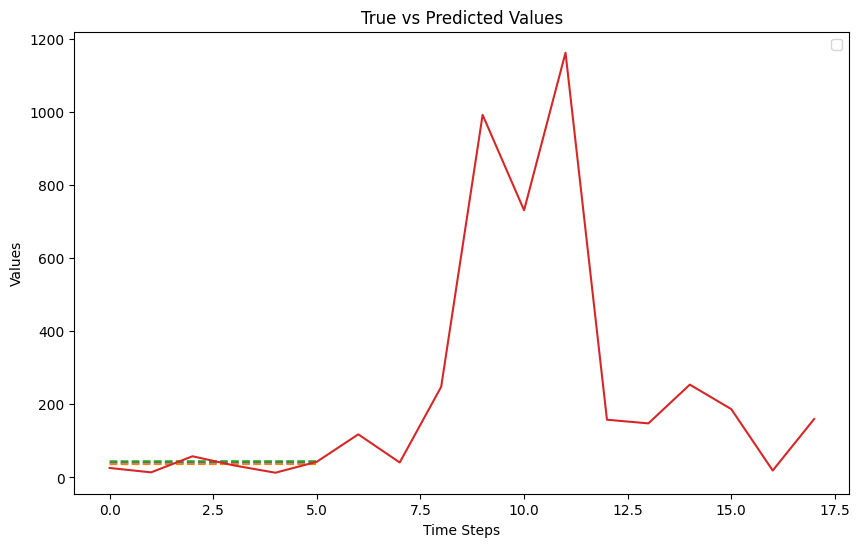

In [96]:
# 预测
with torch.no_grad():
    predictions_set = []
    true_values_set = []
    
    for inputs, targets in X_test:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(-1))  # 添加一个维度以适应LSTM输入
        predictions_set.extend(outputs.tolist())
        true_values_set.extend(targets[-3:].tolist())  # 假设你想要最后3个目标的值

        # print(inputs.unsqueeze(-1))
        # print(outputs)
        # print(targets[-3:])

        # 转换为numpy数组
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
    


    # 绘制真实值与预测值|
    plt.figure(figsize=(10, 6))
    plt.plot(predictions_set, linestyle='dashed')
    plt.plot(true_values_set)
        
    plt.title('True vs Predicted Values')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.legend()
    plt.show()
